# Import libraries and the dataset

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.nn.functional import normalize
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.autograd.grad_mode import no_grad
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import random

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# Set all random factors to be deterministic 
def deterministic(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [3]:
# Load dataset
dataset = pd.read_csv("QQQ.csv")

In [4]:
print(f"dataset shape: {dataset.shape}")

dataset shape: (5952, 7)


In [5]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-03-11,51.43750,51.734375,50.31250,51.3125,44.226849,9688600
1,1999-03-12,51.12500,51.156250,49.65625,50.0625,43.149475,8743600
2,1999-03-15,50.43750,51.562500,49.90625,51.5000,44.388466,6369000
3,1999-03-16,51.71875,52.156250,51.15625,51.9375,44.765564,4905800
4,1999-03-17,51.93750,52.000000,51.40625,51.5625,44.442318,3965000


# Data Processing

In [6]:
# Add a label to the dataset
df_label = np.append(np.array(dataset["Close"][1:]), np.nan)
dataset["Label"] = df_label
dataset

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,1999-03-11,51.437500,51.734375,50.312500,51.312500,44.226849,9688600,50.062500
1,1999-03-12,51.125000,51.156250,49.656250,50.062500,43.149475,8743600,51.500000
2,1999-03-15,50.437500,51.562500,49.906250,51.500000,44.388466,6369000,51.937500
3,1999-03-16,51.718750,52.156250,51.156250,51.937500,44.765564,4905800,51.562500
4,1999-03-17,51.937500,52.000000,51.406250,51.562500,44.442318,3965000,52.562500
...,...,...,...,...,...,...,...,...
5947,2022-10-26,278.459991,283.980011,277.429993,277.929993,277.929993,63492400,272.869995
5948,2022-10-27,276.790009,278.279999,272.339996,272.869995,272.869995,57760300,281.220001
5949,2022-10-28,272.230011,281.700012,272.059998,281.220001,281.220001,62651300,277.950012
5950,2022-10-31,278.920013,279.760010,275.989990,277.950012,277.950012,47742000,275.109985


In [7]:
# A function to create a baseline model
def baseline_prediction(dataframe, look_back):
  baseline = []
  df_close = np.array(dataframe["Close"])
  for i in range(len(dataframe)):
    if i < look_back: 
      baseline.append(np.nan)
    else:
      value = 0
      for j in range(look_back):
        value += df_close[i-j] - df_close[i-j-1]
      value = df_close[i] + value/look_back
      baseline.append(value)
  return baseline

In [8]:
# Create a baseline model with a lookback period of 64
baseline = baseline_prediction(dataset, 64)
dataset["Baseline"] = baseline
dataset

,Date,Open,High,Low,Close,Adj Close,Volume,Label,Baseline
0,1999-03-11,51.437500,51.734375,50.312500,51.312500,44.226849,9688600,50.062500,NaN
1,1999-03-12,51.125000,51.156250,49.656250,50.062500,43.149475,8743600,51.500000,NaN
2,1999-03-15,50.437500,51.562500,49.906250,51.500000,44.388466,6369000,51.937500,NaN
3,1999-03-16,51.718750,52.156250,51.156250,51.937500,44.765564,4905800,51.562500,NaN
4,1999-03-17,51.937500,52.000000,51.406250,51.562500,44.442318,3965000,52.562500,NaN
...,...,...,...,...,...,...,...,...,...
5947,2022-10-26,278.459991,283.980011,277.429993,277.929993,277.929993,63492400,272.869995,277.478743
5948,2022-10-27,276.790009,278.279999,272.339996,272.869995,272.869995,57760300,281.220001,272.292807
5949,2022-10-28,272.230011,281.700012,272.059998,281.220001,281.220001,62651300,277.950012,280.685001
5950,2022-10-31,278.920013,279.760010,275.989990,277.950012,277.950012,47742000,275.109985,277.366887


In [9]:
# Split the dataset into a training, validation and testing set in a ratio of 80:10:10
training_df = dataset.iloc[:4800, :]
validation_df = dataset.iloc[4800:5375, :]
testing_df = dataset.iloc[5375:, :]

In [10]:
print(f"Training datafram shape: {training_df.shape}")
print(f"Validation datafram shape: {validation_df.shape}")
print(f"Testing dataframe shape: {testing_df.shape}")

Training datafram shape: (4800, 9)
Validation datafram shape: (575, 9)
Testing dataframe shape: (577, 9)


In [11]:
# Create custom dataset to the datasets work in batches 
class custom_dataset:
  def __init__(self, dataset, seq_len):
    self._dataset = dataset
    self._seq_len = seq_len
    self._scalar = None
    self._close = None
    self._close_normalized = self.normalized()
    self._feature = self.feature_vector()
    self._label = self.label_vector()
    self._dataset_shape = dataset.shape
  
  # Normalize the dataset
  def normalized(self):
    self._close = self._dataset.loc[:,"Close"].to_numpy()
    self._scalar = MinMaxScaler()
    self._close_normalized = self._scalar.fit_transform(self._close.reshape(-1,1))
    self._close_normalized = self._close_normalized.ravel()
    return self._close_normalized
  
  # Create feature vectors for the dataset(a lookback period of the close price)
  def feature_vector(self):
    self._feature = []
    for value in range(self._seq_len, len(self._close_normalized)):
      self._feature.append(self._close_normalized[(value-self._seq_len):value])
    self._feature = torch.Tensor(self._feature).unsqueeze(2)
    return self._feature
  
  # Create labels for the dataset(close price of tomorrow)
  def label_vector(self):
    self._label = torch.Tensor(self._close_normalized[self._seq_len:].reshape(-1,1))
    return self._label

  # inverse transform the normalized data to original scale
  def inverse_transform(self, pred):
    pred = np.array(pred).reshape(-1,1)
    return self._scalar.inverse_transform(pred).ravel()

  # length of the dataset 
  def __len__(self):
    return self._label.shape[0]
  
  # return (feature vector, label)
  def __getitem__(self, index):
    data = self._feature[index]
    label = self._label[index]
    return (data, label)

In [12]:
# A test to see the custom dataset is working
sequence_length = 10
training_set = custom_dataset(dataset=training_df, seq_len=sequence_length)
validation_set = custom_dataset(dataset=validation_df, seq_len=sequence_length)
testing_set = custom_dataset(dataset=testing_df, seq_len=sequence_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [13]:
print(f"Training set feature shape: {training_set._feature.size()}")
print(f"Training set label shape: {training_set._label.size()}")
print(f"Validation set feature shape: {validation_set._feature.size()}")
print(f"Validation set label shape: {validation_set._label.size()}")
print(f"Testing set feature shape: {testing_set._feature.size()}")
print(f"Testing set label shape: {testing_set._label.size()}")

Training set feature shape: torch.Size([4790, 10, 1])
Training set label shape: torch.Size([4790, 1])
Validation set feature shape: torch.Size([565, 10, 1])
Validation set label shape: torch.Size([565, 1])
Testing set feature shape: torch.Size([567, 10, 1])
Testing set label shape: torch.Size([567, 1])


In [14]:
# Showing the custom dataset return correct feature vectors and labels
print(f"feature: {training_set._feature[-2]}, label: {training_set._label[-2]}")
print(f"feature: {training_set._feature[-1]}, label: {training_set._label[-1]}")

feature: tensor([[0.9535],
        [0.9268],
        [0.8989],
        [0.9372],
        [0.9026],
        [0.8907],
        [0.9094],
        [0.8794],
        [0.8908],
        [0.9069]]), label: tensor([0.9128])
feature: tensor([[0.9268],
        [0.8989],
        [0.9372],
        [0.9026],
        [0.8907],
        [0.9094],
        [0.8794],
        [0.8908],
        [0.9069],
        [0.9128]]), label: tensor([0.8867])


In [15]:
# A test of putting custom datasets into data loaders
batch_size = 32
train_loader = DataLoader(dataset=training_set, batch_size=batch_size)
valid_loader = DataLoader(dataset=validation_set, batch_size=batch_size)
test_loader = DataLoader(dataset=testing_set, batch_size=batch_size)

# Model Building

In [16]:
# RNN 
class RNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, seq_len):
    super(RNN, self).__init__()
    self._input_dim = input_dim
    self._hidden_dim = hidden_dim
    self._layer_dim = layer_dim
    self._out = None
    self._h_c = None
    # RNN cell layer
    self._layer_1 = nn.RNN(input_size=self._input_dim, hidden_size=self._hidden_dim, num_layers=self._layer_dim, nonlinearity="relu", batch_first=True)
    # Fully connected layer
    self.fc = nn.Linear(in_features=self._hidden_dim, out_features=1)
  
  def forward(self, x):
    # Initial hidden state
    hidden_state = torch.zeros(self._layer_dim, x.size(0), self._hidden_dim).to(device=device)

    self._out, self._h = self._layer_1(x, hidden_state.detach())
    self._out = self._out[:,-1,:].reshape(self._out.size(0), -1)
    self._out = self.fc(self._out)
    return self._out
  

In [17]:
# LSTM
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, seq_len):
    super(LSTM, self).__init__()
    self._input_dim = input_dim
    self._hidden_dim = hidden_dim
    self._layer_dim = layer_dim
    self._out = None
    self._h_c = None
    # LSTM cell layer
    self._layer_1 = nn.LSTM(input_size=self._input_dim, hidden_size=self._hidden_dim, num_layers=self._layer_dim, batch_first=True)
    # Fully connected layer
    self.fc = nn.Linear(in_features=self._hidden_dim, out_features=1)
  
  def forward(self, x):
    # Initial hidden state and cell state
    hidden_state = torch.zeros(self._layer_dim, x.size(0), self._hidden_dim).to(device=device) # Hidden state size = (layer length, batch size, hidden size)
    cell_state = torch.zeros(self._layer_dim, x.size(0), self._hidden_dim).to(device=device)

    self._out, self._h = self._layer_1(x, (hidden_state.detach(), cell_state.detach()))
    self._out = self._out[:,-1,:].reshape(self._out.size(0), -1)
    self._out = self.fc(self._out)
    return self._out
  

In [18]:
# GRU
class GRU(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, seq_len):
    super(GRU, self).__init__()
    self._input_dim = input_dim
    self._hidden_dim = hidden_dim
    self._layer_dim = layer_dim
    self._out = None
    self._h = None
    # GRU cell layer
    self._layer_1 = nn.RNN(input_size=self._input_dim, hidden_size=self._hidden_dim, num_layers=self._layer_dim, batch_first=True)
    # Fully connected layer
    self.fc = nn.Linear(in_features=self._hidden_dim, out_features=1)
  
  def forward(self, x):
    # Initial hidden state
    hidden_state = torch.zeros(self._layer_dim, x.size(0), self._hidden_dim).to(device=device)

    self._out, self._h = self._layer_1(x, hidden_state.detach())
    self._out = self._out[:,-1,:].reshape(self._out.size(0), -1)
    self._out = self.fc(self._out)
    return self._out

In [19]:
# Plot learning curve
def learning_curve(train_loss_list, valid_loss_list):
  fig, ax = plt.subplots(1,2,figsize=[12,8])
  ax[0].plot([i for i in range(len(train_loss_list))], train_loss_list)
  ax[1].plot([i for i in range(len(valid_loss_list))], valid_loss_list, c="orange")
  ax[0].set_title("Training Loss")
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Loss")
  ax[1].set_title("Validation Loss")
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Loss")
  return fig

In [21]:
# Training of the model
def train(model, train_data, valid_data, max_epochs, early_stopping=5, min_improvement=1e-3, verbose=False, lr_curve=False):
  # Parameter
  epoch = 1
  train_loss_list = []
  valid_loss_list = []
  n_no_improvement = 0
  min_loss = np.inf
  while epoch <= max_epochs and n_no_improvement < early_stopping:
    # Training with the training set
    model.train()
    for (data, label) in train_data:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.float32)

      outputs = model(data)

      loss = criterion(outputs, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    # Evaluate with the training set
    with torch.no_grad():
      model.eval()
      loss = 0
      for (data, label) in train_data:
        data = data.to(device=device, dtype=torch.float32)
        label = label.cpu().detach().numpy()
        outputs = model(data).cpu().detach().numpy()
        loss += mean_squared_error(outputs, label)
      train_loss_list.append(loss.item())

    # Evaluate with the validation set
    with torch.no_grad():
      model.eval()
      loss = 0
      for (data, label) in valid_data:
        data = data.to(device=device, dtype=torch.float32)
        label = label.cpu().detach().numpy()
        outputs = model(data).cpu().detach().numpy()
        loss += mean_squared_error(outputs, label)
      valid_loss_list.append(loss.item())
      # Print training epochs' details
      if verbose == True:
        print(f"epoch:{epoch} loss:{loss}")
      
      # Early stopping 
      if min_loss-loss.item() > min_improvement:
        min_loss = loss.item()
        n_no_improvement = 0
      else:
        n_no_improvement += 1

    epoch += 1
  print(f"final loss: {valid_loss_list[-1]}, number of epoch: {epoch-1}")

  # Print a learning curve
  if lr_curve == True:
    fig = learning_curve(train_loss_list, valid_loss_list)
    return model, fig
  else:
    return model, valid_loss_list

In [22]:
# A function for evaluation 
def evaluate(model, test_data):
  model.eval()
  loss = 0
  prediction = []
  with torch.no_grad():
    for (data, label) in test_data:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.float32)
      outputs = model(data)
      loss += torch.square(outputs-label).sum()
      for value in outputs:
        prediction.append(value.item())
  return outputs, prediction

# Grid Search of the Optimal Setting

In [23]:
# Grid search for the optimal setting in types of the model, sequence lengths, hidden sizes and the number of layers
deterministic(seed=0)

summary = []
for model_type in ["rnn", "lstm", "gru"]:
  for sequence in [2, 16, 64]:
    for hidden_size in [2, 32, 128]:
      for layer_num in [1, 2, 3]:
        # Set sequence
        seq_len = sequence 
        # Create respective datasets
        training_set = custom_dataset(dataset=training_df, seq_len=seq_len)
        validation_set = custom_dataset(dataset=validation_df, seq_len=seq_len)
        testing_set = custom_dataset(dataset=testing_df, seq_len=seq_len)
        # Create respective dataloaders
        batch_size = 256
        train_loader = DataLoader(dataset=training_set, batch_size=batch_size)
        valid_loader = DataLoader(dataset=validation_set, batch_size=batch_size)
        test_loader = DataLoader(dataset=testing_set, batch_size=batch_size)
        
        input_dim = 1
        # Set hidden sizes 
        hidden_dim = hidden_size
        # Set layers 
        layer_dim = layer_num
        # Create the model
        if model_type == "rnn":
          model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, seq_len=seq_len).to(device)
        elif model_type == "lstm":
          model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, seq_len=seq_len).to(device)
        elif model_type == "gru":
          model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, seq_len=seq_len).to(device)
        criterion = nn.MSELoss()
        learning_rate = 0.05
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        print(f"model:{model_type} sequence length: {sequence} layer_dim: {layer_num} hidden size: {hidden_dim}")
        model, valid_loss = train(model=model, train_data=train_loader, valid_data=valid_loader, max_epochs=100, early_stopping=10, min_improvement=0,
                                    verbose=False, lr_curve=False)
        summary.append([model_type, sequence, hidden_size, layer_num, len(valid_loss), valid_loss[-1]])
        print("\n")

model:rnn sequence length: 2 layer_dim: 1 hidden size: 2
final loss: 0.002001175715122372, number of epoch: 73


model:rnn sequence length: 2 layer_dim: 2 hidden size: 2
final loss: 0.17580739129334688, number of epoch: 44


model:rnn sequence length: 2 layer_dim: 3 hidden size: 2
final loss: 0.1860686708241701, number of epoch: 11


model:rnn sequence length: 2 layer_dim: 1 hidden size: 32
final loss: 0.0019961764046456665, number of epoch: 63


model:rnn sequence length: 2 layer_dim: 2 hidden size: 32
final loss: 0.0021124413469806314, number of epoch: 100


model:rnn sequence length: 2 layer_dim: 3 hidden size: 32
final loss: 0.002099802019074559, number of epoch: 100


model:rnn sequence length: 2 layer_dim: 1 hidden size: 128
final loss: 0.0019989247084595263, number of epoch: 59


model:rnn sequence length: 2 layer_dim: 2 hidden size: 128
final loss: 0.0020781329658348113, number of epoch: 70


model:rnn sequence length: 2 layer_dim: 3 hidden size: 128
final loss: 0.0021123046753

# Analysis of the Grid Search

In [24]:
# Summary of the grid search
summary_df = pd.DataFrame(summary, columns=["Model", "Sequence length", "Hidden size", "Layer", "Epoch", "Loss"]).sort_values("Loss")
summary_df
#summary_df.to_csv("Result.csv")

,Model,Sequence length,Hidden size,Layer,Epoch,Loss
24,rnn,64,128,1,100,0.001658
25,rnn,64,128,2,100,0.001804
21,rnn,64,32,1,77,0.001933
18,rnn,64,2,1,98,0.001989
3,rnn,2,32,1,63,0.001996
...,...,...,...,...,...,...
29,lstm,2,2,3,16,0.188977
11,rnn,16,2,3,66,0.192418
44,lstm,16,128,3,13,0.196989
37,lstm,16,2,2,11,0.209488


In [25]:
# Mean and SD of the types of the model
for model_type in ["rnn", "lstm", "gru"]:
  loss_distrib = summary_df[summary_df["Model"]== model_type]["Loss"]
  print(f"sum:{loss_distrib.sum()} mean:{loss_distrib.mean()} std:{loss_distrib.std()}")

sum:0.9226982101681642 mean:0.03417400778400608 std:0.06552526055878212
sum:2.209848379046889 mean:0.0818462362609959 std:0.07895385510851986
sum:0.40092201565857977 mean:0.014848963542910362 std:0.04165954762048193


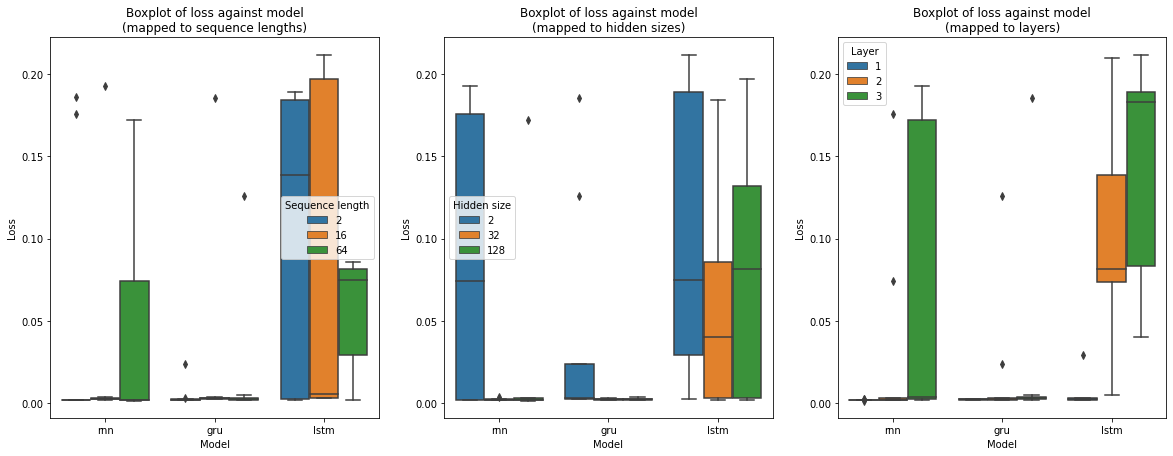

In [26]:
# Boxplots of types of the model
fig, ax = plt.subplots(1,3,figsize=[20,7])
sns.boxplot(data=summary_df, x="Model", y="Loss", hue="Sequence length", ax=ax[0])
sns.boxplot(data=summary_df, x="Model", y="Loss", hue="Hidden size", ax=ax[1])
sns.boxplot(data=summary_df, x="Model", y="Loss", hue="Layer", ax=ax[2])
ax[0].set_title("Boxplot of loss against model\n(mapped to sequence lengths)")
ax[1].set_title("Boxplot of loss against model\n(mapped to hidden sizes)")
ax[2].set_title("Boxplot of loss against model\n(mapped to layers)")
fig.savefig("model_all.png")

In [27]:
# Mean and SD of the sequence length
for sequence in [2, 16, 64]:
  loss_distrib = summary_df[summary_df["Sequence length"]== sequence]["Loss"]
  print(f"sum:{loss_distrib.sum()} mean:{loss_distrib.mean()} std:{loss_distrib.std()}")

sum:1.4395211498776916 mean:0.053315598143618206 std:0.07948206244497617
sum:1.1023591449775267 mean:0.040828116480649136 std:0.0774065160852206
sum:0.9915883100184146 mean:0.03672549296364499 std:0.047626255998836964


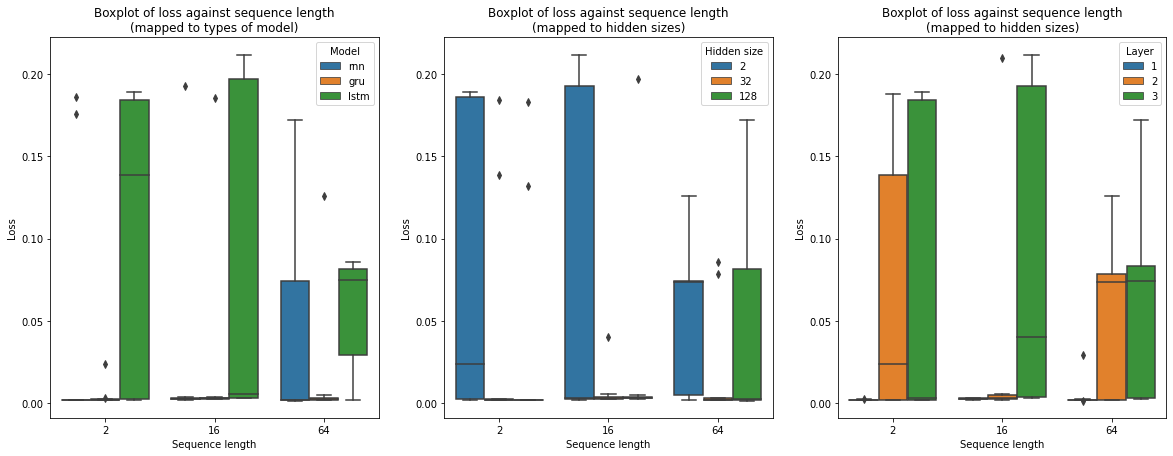

In [28]:
# Boxplots of types of the sequence lengths
fig, ax = plt.subplots(1,3,figsize=[20,7])
sns.boxplot(data=summary_df, x="Sequence length", y="Loss", hue="Model", ax=ax[0])
sns.boxplot(data=summary_df, x="Sequence length", y="Loss", hue="Hidden size", ax=ax[1])
sns.boxplot(data=summary_df, x="Sequence length", y="Loss", hue="Layer", ax=ax[2])
ax[0].set_title("Boxplot of loss against sequence length\n(mapped to types of model)")
ax[1].set_title("Boxplot of loss against sequence length\n(mapped to hidden sizes)")
ax[2].set_title("Boxplot of loss against sequence length\n(mapped to hidden sizes)")
fig.savefig("sequence_all.png")

In [29]:
# Mean and SD of the hidden sizes
for hidden_size in [2, 32, 128]:
  loss_distrib = summary_df[summary_df["Hidden size"] == hidden_size]["Loss"]
  print(f"sum:{loss_distrib.sum()} mean:{loss_distrib.mean()} std:{loss_distrib.std()}")

sum:2.0462042833678424 mean:0.07578534382843861 std:0.08341923779617891
sum:0.5850831292918883 mean:0.021669745529329196 std:0.046282824810843705
sum:0.9021811922139022 mean:0.03341411823014453 std:0.06283885773148588


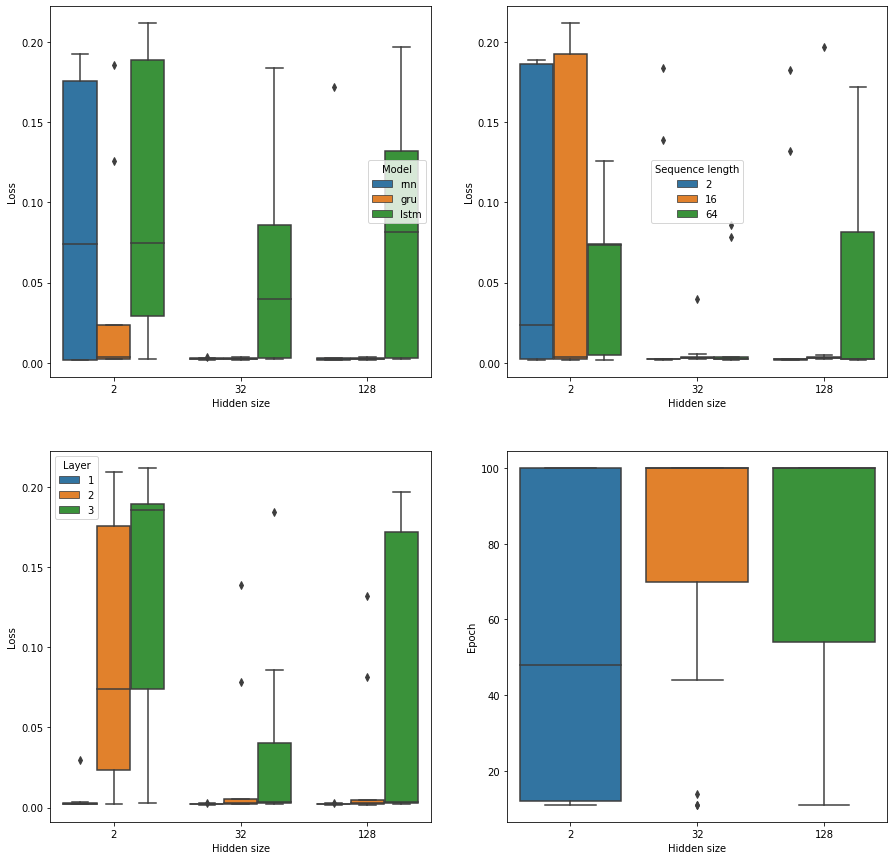

In [30]:
# Boxplots of types of the hidden sizes
fig, ax = plt.subplots(2,2,figsize=[15,15])
sns.boxplot(data=summary_df, x="Hidden size", y="Loss", hue="Model", ax=ax[0][0])
sns.boxplot(data=summary_df, x="Hidden size", y="Loss", hue="Sequence length", ax=ax[0][1])
sns.boxplot(data=summary_df, x="Hidden size", y="Loss", hue="Layer", ax=ax[1][0])
sns.boxplot(data=summary_df, x="Hidden size", y="Epoch", ax=ax[1][1])

In [31]:
# Mean and SD of the number of layers
for layer_num in [1, 2, 3]:
  loss_distrib = summary_df[summary_df["Layer"] == layer_num]["Loss"]
  print(f"sum:{loss_distrib.sum()} mean:{loss_distrib.mean()} std:{loss_distrib.std()}")

sum:0.08933979683206417 mean:0.003308881364150525 std:0.0052507274205277595
sum:1.34559079297469 mean:0.04983669603609963 std:0.0678820372521258
sum:2.098538015066879 mean:0.07772363018766218 std:0.08462595998515375


Text(0.5, 1.0, 'Boxplot of loss against layer\n(mapped to hidden sizes)')

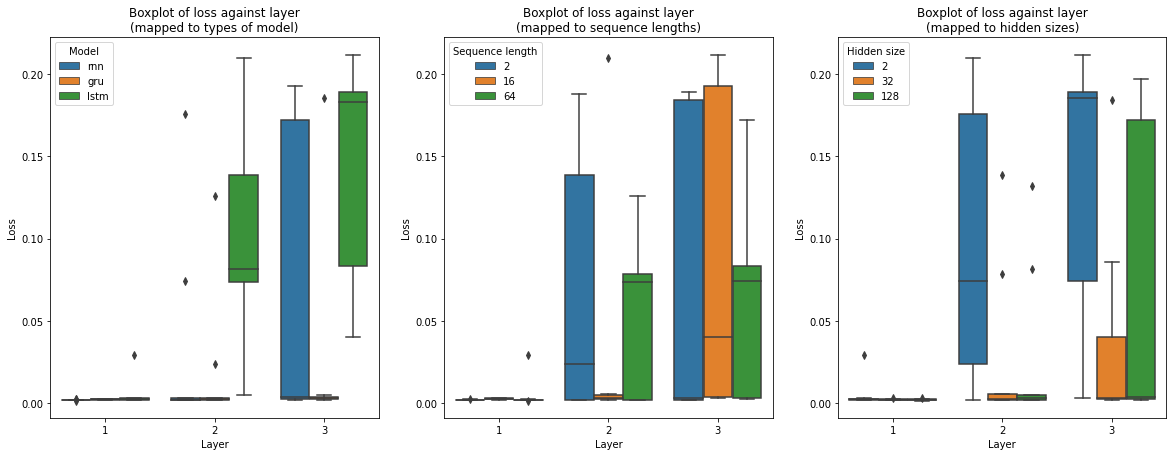

In [32]:
# Boxplots of types of the number of layers
fig, ax = plt.subplots(1,3,figsize=[20,7])
sns.boxplot(data=summary_df, x="Layer", y="Loss", hue="Model", ax=ax[0])
sns.boxplot(data=summary_df, x="Layer", y="Loss", hue="Sequence length", ax=ax[1])
sns.boxplot(data=summary_df, x="Layer", y="Loss", hue="Hidden size", ax=ax[2])
ax[0].set_title("Boxplot of loss against layer\n(mapped to types of model)")
ax[1].set_title("Boxplot of loss against layer\n(mapped to sequence lengths)")
ax[2].set_title("Boxplot of loss against layer\n(mapped to hidden sizes)")
#fig.savefig("layer_all.png")

# Evaluation

In [34]:
# MSE of the label and the baseline
ground_true = testing_set.inverse_transform(testing_set._label) # Unnormalize the label in the testing set
time_axis = pd.to_datetime(testing_set._dataset["Date"][-(ground_true.shape[0]):]) # Set x-axis as date
baseline_prediction = testing_df["Baseline"][-(ground_true.shape[0])-1:-1] # Extract baseline data
mean_squared_error(y_pred=baseline_prediction, y_true=ground_true) # MSE of the label and the baseline

26.620108355130274

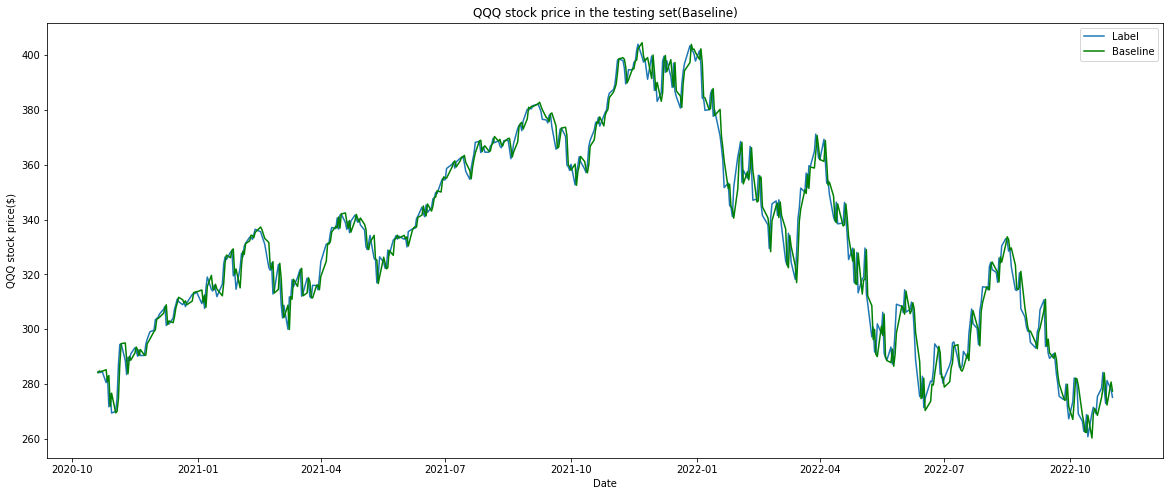

In [35]:
# Line plot of labels and baseline predictions
plt.figure(figsize=[20,8])
plt.plot(time_axis, ground_true, label="Label")
plt.plot(time_axis, baseline_prediction, c="g", label="Baseline")
plt.title("QQQ stock price in the testing set(Baseline)")
plt.xlabel("Date")
plt.ylabel("QQQ stock price($)")
plt.legend()
#plt.savefig("baseline prediction")

Text(0.5, 0, 'Price difference($)')

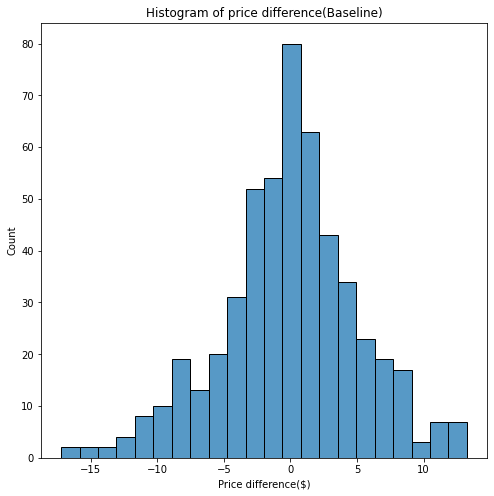

In [36]:
# Distribution of the price difference between labels and baseline predictions
fig, ax = plt.subplots(1,1,figsize=[8,8])
sns.histplot(ground_true-baseline_prediction, ax=ax)
ax.set_title("Histogram of price difference(Baseline)")
ax.set_xlabel("Price difference($)")

final loss: 0.0015854948142077774, number of epoch: 100


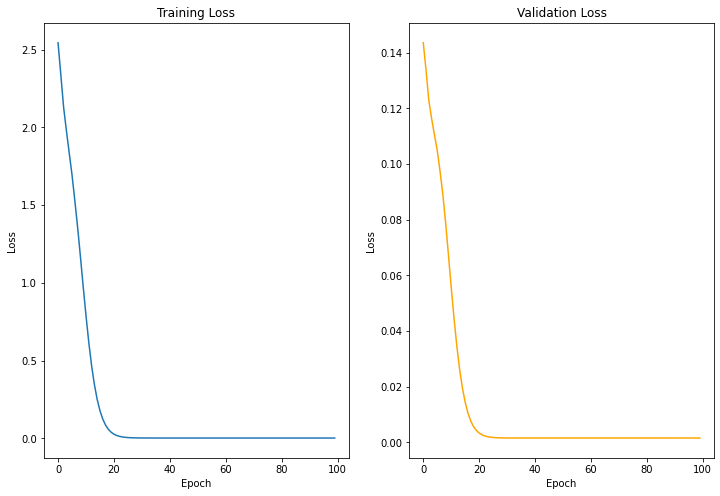

In [37]:
# Passing best model into the testing set
deterministic(seed=0)

seq_len = 64
training_set = custom_dataset(dataset=training_df, seq_len=seq_len)
validation_set = custom_dataset(dataset=validation_df, seq_len=seq_len)
testing_set = custom_dataset(dataset=testing_df, seq_len=seq_len)
batch_size = 256
train_loader = DataLoader(dataset=training_set, batch_size=batch_size)
valid_loader = DataLoader(dataset=validation_set, batch_size=batch_size)
test_loader = DataLoader(dataset=testing_set, batch_size=batch_size)
input_dim = 1
hidden_dim = 128
layer_dim = 1
rnn = RNN(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, seq_len=seq_len).to(device)
criterion = nn.MSELoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
rnn, valid_loss = train(model=rnn, train_data=train_loader, valid_data=valid_loader, max_epochs=100, early_stopping=10, min_improvement=0,
                            verbose=False, lr_curve=True)

In [38]:
# MSE loss of labels and the prediction from the best model
outputs, prediction = evaluate(rnn, test_loader)
predictions = testing_set.inverse_transform(prediction)
mean_squared_error(y_pred=predictions, y_true=ground_true)

34.82002755317491

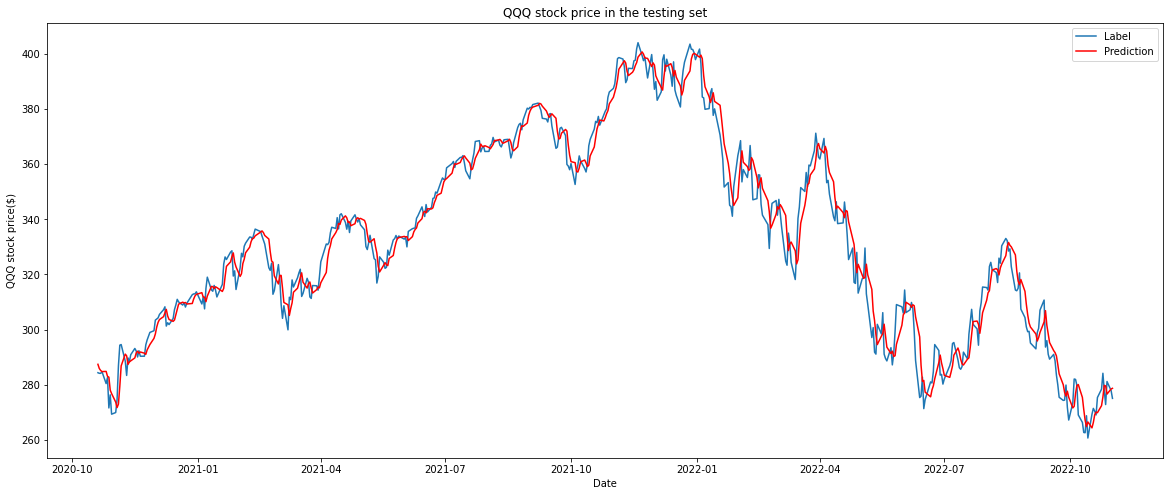

In [39]:
# Line plot of labels and the best model predictions
plt.figure(figsize=[20,8])
ground_true = testing_set.inverse_transform(testing_set._label)
time_axis = pd.to_datetime(testing_set._dataset["Date"][-(ground_true.shape[0]):])
plt.plot(time_axis, ground_true, label="Label")
plt.plot(time_axis, predictions, c="r", label="Prediction")
plt.title("QQQ stock price in the testing set")
plt.xlabel("Date")
plt.ylabel("QQQ stock price($)")
plt.legend()
plt.savefig("RNN prediction")

Text(0.5, 0, 'Price difference($)')

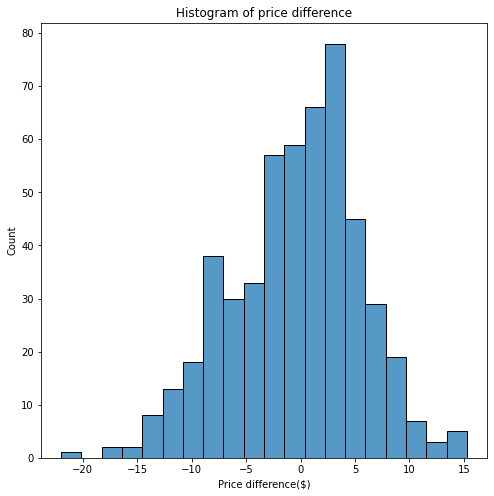

In [40]:
# Distribution of the price difference between labels and baseline predictions
fig, ax = plt.subplots(1,1,figsize=[8,8])
sns.histplot(testing_set.inverse_transform(testing_set._label)-predictions, ax=ax)
ax.set_title("Histogram of price difference")
ax.set_xlabel("Price difference($)")
#fig.savefig("price_difference.png")